

## Time Series Clustering  -  LIS/OTD Monthly Time Series


In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
crs = {'init': 'epsg:4326'}

In [3]:
frd = Dataset('./LIS_VHRES/data_climatology/LISOTD_LRMTS.nc', 'r').variables['LRMTS_COM_FR'][:].data
#frd = frd[ : , :, :] #keep the measurements from April 2000 onwards (LIS)
frd.shape

(72, 144, 240)

In [4]:
#create two functions to tranfrorm the coords back and forth
res = 2.5
zone = 90

def gridded_latlon(real_lat, real_lon):
    grid_lat = round((real_lat + zone)/res)
    grid_lon = round((real_lon + 180)/res)
    print(grid_lat, grid_lon)
    return grid_lat, grid_lon


def real_latlon(grid_lat, grid_lon):
    real_lat = grid_lat*res - zone
    real_lon = grid_lon*res - 180
    print(real_lat, real_lon)
    return real_lat, real_lon
    

In [5]:
#Choose 2 spots, one from northern and one from the southern hemisphere and check the anticorrelation 
north = gridded_latlon(25, -103)
south = gridded_latlon(-20, -65)

46 31
28 46


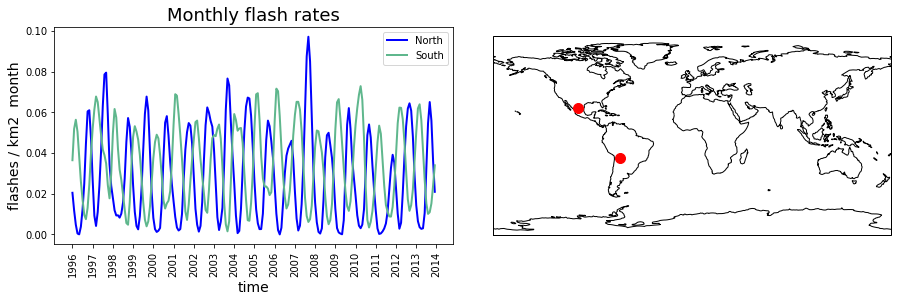

In [15]:
#plot 19 years: January 1996 - January 2015
ser_north = pd.Series(frd[46, 31, 9:225])
ser_south = pd.Series(frd[28, 46, 9:225])


plt.close('all')
f = plt.figure(figsize=((15,4))) 

#plot the time series for the two spots
ax = f.add_subplot(121)
ax.plot(ser_north, linewidth=2, c='b',       label='North')
ax.plot(ser_south, linewidth=2, c='#5fb78d', label = 'South')
plt.legend(loc='upper right')
ax.set_xticks(np.arange(0, 228, 12))
ax.set_xticklabels(list(np.arange(1996, 2016)), rotation='vertical')
ax.set_xlabel("time", fontsize=14)
ax.set_ylabel('flashes / km2  month', fontsize=14)
ax.set_title('Monthly flash rates', fontsize=18)

#plot the two spots on the map
ax = f.add_subplot(122, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-180, 180, -90, 90])
ax.plot(-103, 25, 'ro', markersize=10) 
ax.plot(-65, -20, 'ro', markersize=10) 

plt.subplots_adjust(wspace=0.1)

plt.savefig('North-South_time series.png', bbox_inches='tight')

plt.show()


In [16]:
#Choose 3 random spots with different flash rates: ocean, high elevation and convergence zone
#find the corresponding gridded coordinates
ocean     = gridded_latlon(-20, -160)
high_elev = gridded_latlon(33, 72)
conv_zone = gridded_latlon(10, 15)

28 8
49 101
40 78


In [17]:
#normalization
import dask.array as da
frd_da = da.from_array(frd, chunks=(31, 144, 180))

fx = lambda x: (x - np.nanmean(x)) / np.nanstd(x)

frd_norm = da.apply_along_axis(fx, 2, frd_da).compute()

/home/student/anaconda3/envs/BigData/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/student/anaconda3/envs/BigData/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


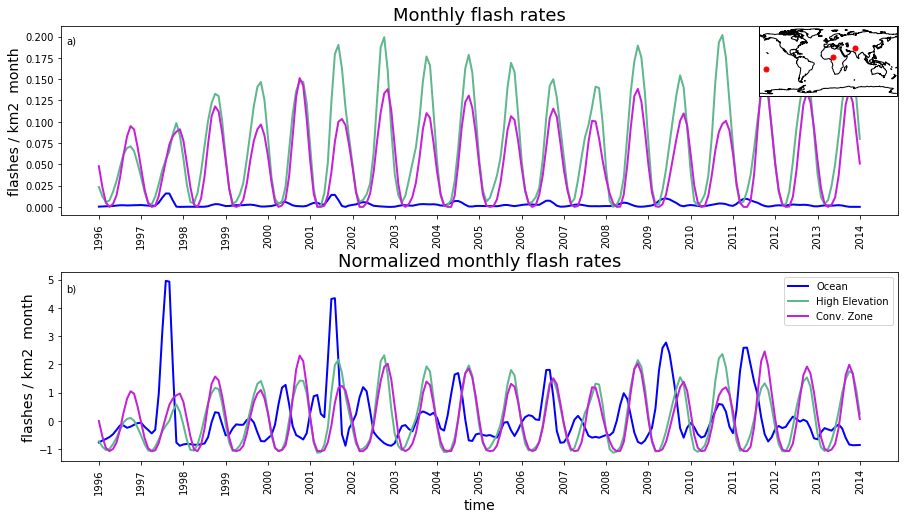

In [76]:
#keep 10 years (for the plot): January 2001 - January 2014
ser_ocean     = pd.Series(frd[28, 8, 9:226])
ser_high_elev = pd.Series(frd[49, 101, 9:226])
ser_conv_zone = pd.Series(frd[40, 78, 9:226])

plt.close('all')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=((15,8))) 


ax1.plot(ser_ocean,     linewidth=2, c='b',       label='Ocean')
ax1.plot(ser_high_elev, linewidth=2, c='#5fb78d', label = 'High Elevation')
ax1.plot(ser_conv_zone, linewidth=2, c='#c620d8', label= 'Conv. Zone')
ax1.set_xticks(np.arange(0, 218, 12))
ax1.set_xticklabels(list(np.arange(1996, 2015)), rotation='vertical')
ax1.set_ylabel('flashes / km2  month', fontsize=14)
plt.figtext(0.13, 0.85, 'a)')
ax1.set_title('Monthly flash rates', fontsize=18)


ax2.plot(pd.Series(frd_norm[28, 8, 9:226 ]),   linewidth=2, c='b',       label='Ocean')
ax2.plot(pd.Series(frd_norm[49, 101, 9:226 ]), linewidth=2, c='#5fb78d', label = 'High Elevation')
ax2.plot(pd.Series(frd_norm[40, 78, 9:226 ]),  linewidth=2, c='#c620d8', label= 'Conv. Zone')
ax2.legend(loc='upper right')
ax2.set_xticks(np.arange(0, 218, 12))
ax2.set_xticklabels(list(np.arange(1996, 2015)), rotation='vertical')
ax2.set_xlabel("time", fontsize=14)
ax2.set_ylabel('flashes / km2  month', fontsize=14)
plt.figtext(0.13, 0.42, 'b)')
ax2.set_title('Normalized monthly flash rates', fontsize=18)


ax3 = fig.add_axes([0.76, 0.76, 0.15, 0.12], projection=ccrs.PlateCarree())
ax3.coastlines()
ax3.set_extent([-180, 180, -90, 90])
ax3.plot(-160, -20, 'ro', markersize=5) 
ax3.plot(72, 33, 'ro', markersize=5) 
ax3.plot(15, 10, 'ro', markersize=5) 

plt.subplots_adjust(hspace=0.3)

plt.savefig('3 random places_time series.png', bbox_inches='tight')

plt.show()


In [77]:
#keep the tropicals and subtropicals: lat=[-38, 38]
frd_cut = frd[21:52, :, : ] 
frd_norm_cut = frd_norm[21:52, :, :]

frd_cut.shape

(31, 144, 240)

In [78]:
#create a mask, where the flashes are constantly low (their sum will be low as well)
mask = np.asarray([np.sum(frd_cut, 2)<=0.05]).reshape((31, 144)) 

frd_clean = frd_norm_cut[~mask, :]
shape = frd_clean.shape
print(frd_clean.shape)

(3935, 240)


In [79]:
#Compute linkage matrices

method = 'complete' 
metric = 'correlation' 

linkage_file = 'linkage_lis12-%s-%s.npy' % (method, metric) 
z = linkage(frd_clean, method = method, metric = metric)
np.save(linkage_file, z)
z.shape

(3934, 4)

### Seasonal Cluster Analysis

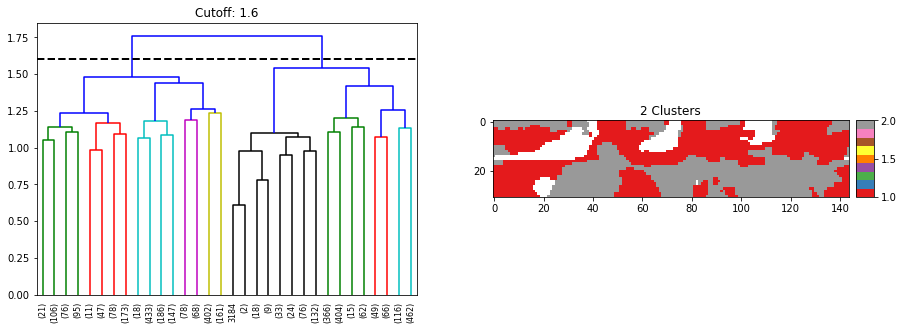

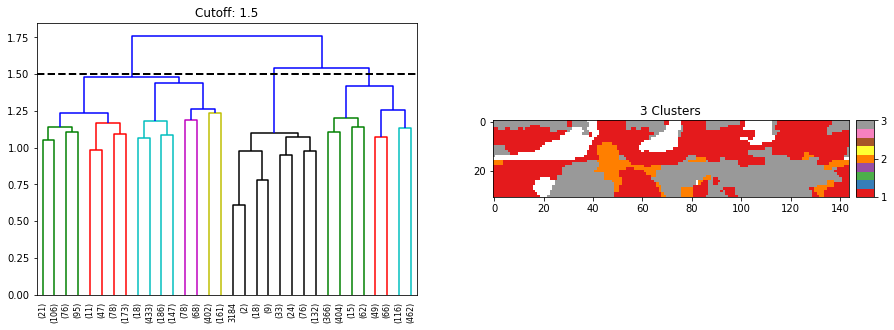

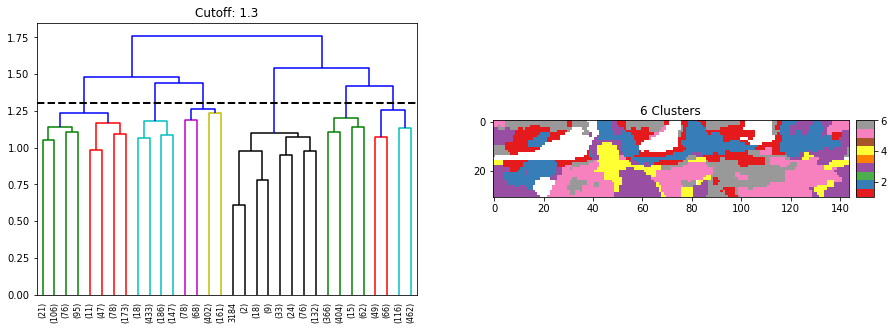

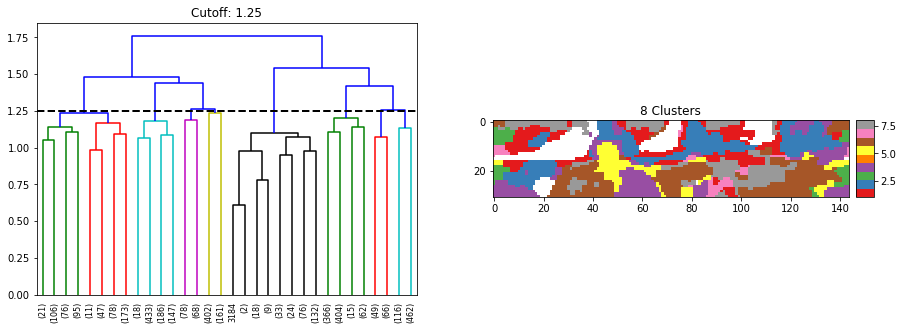

In [80]:
for cutoff in [1.6, 1.5, 1.3, 1.25]:
    f, (ax,ax2) = plt.subplots(1,2, figsize=(15,5))
    
    #Plot the dendrogram
    ax.set_title(str('Cutoff: ') + str(cutoff))
    dendrogram(z, ax=ax, p=4, truncate_mode='level',  leaf_rotation=90.)
    ax.plot((0,1000), (cutoff,cutoff), 'k--', linewidth=2)
    
    #Create the clusters
    clst = fcluster(z, cutoff, criterion='distance') # matrix with shape of input data
    
    #Create an empty array to hold the clusters -- this since we 'flattened' the ds_clean array, we need to 
    #change the shape of the input
    ci = np.ones(31*144) # shape of original data
    ci.fill(np.nan)
    ci[~mask.ravel()] = clst # everywere were there is no mask I put the cluster value
    ci = ci.reshape(31,144)
    a = ax2.imshow(ci,cmap=plt.cm.Set1)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(a, cax=cax)
    num_clusts = str(np.unique(clst).shape[0])
    ax2.set_title(num_clusts + ' Clusters')
    


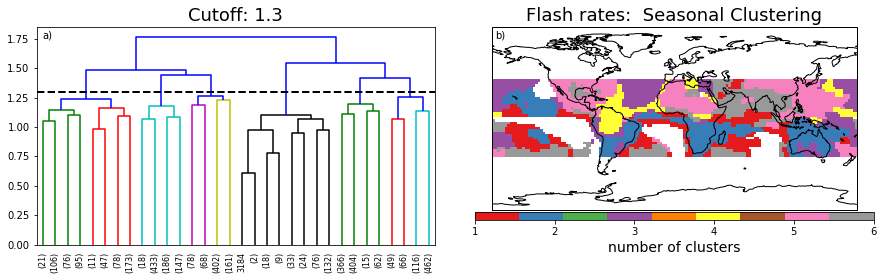

In [81]:
cutoff = 1.3

f = plt.figure(figsize=(15,4))    


#Plot the dendrogram
ax = f.add_subplot(121)
ax.set_title(str('Cutoff: ') + str(cutoff), fontsize = 18)
dendrogram(z, ax=ax, p=4, truncate_mode='level',  leaf_rotation=90.)
ax.plot((0,1000), (cutoff,cutoff), 'k--', linewidth=2)
plt.figtext(0.13, 0.84, 'a)')

    
#Create the clusters
clst = fcluster(z, cutoff, criterion='distance') 
cluster_numbers = np.unique(clst)
num_clusts = str(cluster_numbers.shape[0])


#Create an empty array to hold the clusters 
ci = np.ones(31*144) 
ci.fill(np.nan)
ci[~mask.ravel()] = clst 
ci = ci.reshape(31,144)


ax = f.add_subplot(122, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90])
ax.coastlines()
img = ax.imshow(ci,cmap=plt.cm.Set1, extent = [-180, 180, -38, 38])
plt.figtext(0.55, 0.84, 'b)')
ax.set_title('Flash rates:  Seasonal Clustering', fontsize=18)

cb = plt.colorbar(img, ax=ax, orientation='horizontal',  pad=0.01, aspect = 50)
cb.ax.set_xlabel('number of clusters', fontsize=14)

plt.subplots_adjust(wspace=0.1)

plt.savefig('Seasonal clustering.png', bbox_inches='tight')

plt.show()
 

In [82]:
#Grouped statistics
#cutoff = 1.5

print(cluster_numbers.shape[0], 'Clusters')

means = np.nanmean(frd_cut, axis=2)
means = np.array(means)

#Print the sizes of each cluster
for cluster in cluster_numbers:
    idx = np.where(ci == cluster)
    print(cluster, ':', ci[idx].shape)
    print('Mean of Means:', np.nanmean(means[idx]))
    print('STD of Means:', np.nanstd(means[idx]))
    
#Means aren't that different
#Deviations are very low

6 Clusters
1 : (607,)
Mean of Means: 0.0047335373
STD of Means: 0.009991645
2 : (784,)
Mean of Means: 0.015121997
STD of Means: 0.019979885
3 : (709,)
Mean of Means: 0.0069482243
STD of Means: 0.01760967
4 : (295,)
Mean of Means: 0.017530603
STD of Means: 0.02455123
5 : (847,)
Mean of Means: 0.015235566
STD of Means: 0.01706272
6 : (693,)
Mean of Means: 0.013658437
STD of Means: 0.020436104


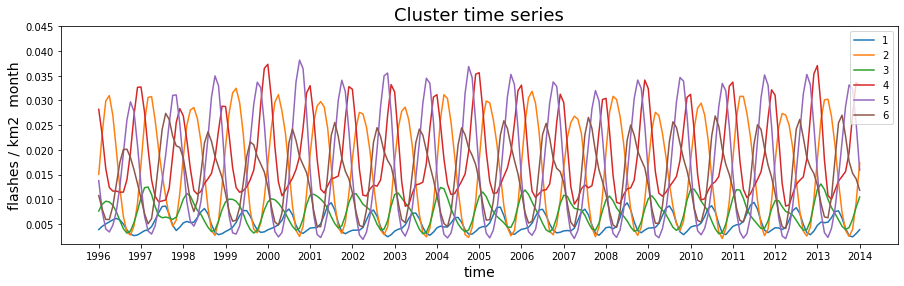

In [84]:
#plot cluster time series for the case of 5 clusters

#January 1996 - January 2015
ds = np.array(frd_cut[:,:, 9:226])

plt.close('all')
f,ax = plt.subplots(1, figsize = (15,4))
for cluster in cluster_numbers[:]:                  
    idx = np.where(ci == cluster)
    all_frd = ds[idx]                               #it takes all the time series within a given cluster
    mean_frd = pd.Series(np.nanmean(all_frd, 0))    #it makes a mean time series
    ax.plot(mean_frd.values, label=str(cluster))
ax.legend(loc='upper right')
ax.set_xticks(np.arange(0, 218, 12))
ax.set_xticklabels(list(np.arange(1996, 2015)))
ax.set_xlabel("time", fontsize=14)
ax.set_ylim(0.001, 0.045)
ax.set_ylabel('flashes / km2  month', fontsize=14)
ax.set_title('Cluster time series', fontsize=18)

plt.savefig('Cluster time series.png', bbox_inches='tight')

plt.show()

In [85]:
#Save the averaged 'master' time series for each cluster
master = np.empty((cluster_numbers.shape[0], ds.shape[2]))
for i, cluster in enumerate(cluster_numbers):
    idx = np.where(ci == cluster)
    all_frd = ds[idx]
    mean_frd = np.nanmean(all_frd, 0)
    master[i,:] = mean_frd
master = master[:, :]
master.shape

(6, 217)

### De-seasoning

In [86]:
ser = pd.Series(master[1,:])

import statsmodels.api as sm   
decomp = sm.tsa.seasonal_decompose(ser, model='additive', period=12)

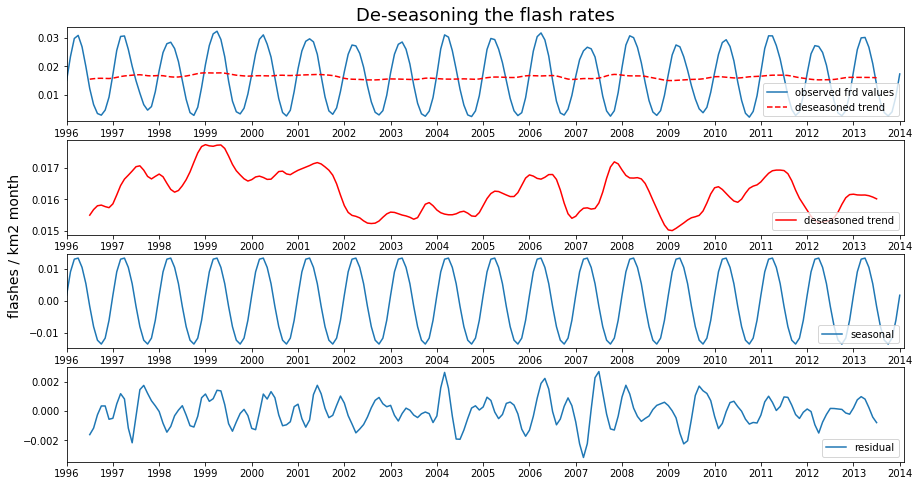

In [97]:
plt.close('all')
f, ax = plt.subplots(4, figsize=(15,8))

time = list(np.arange(1996, 2015))

ax[0].plot(ser.index, ser.values, label = 'observed frd values')
ax[0].plot(ser.index, decomp.trend, 'r--', label = 'deseasoned trend')
ax[0].legend(loc = 'lower right')
ax[0].set_xlim(0, 217)
ax[0].set_xticks(np.arange(0, 217, 12))
ax[0].set_xticklabels(time)

ax[1].plot(ser.index, decomp.trend, 'r',label = 'deseasoned trend')
ax[1].legend(loc = 'lower right')
ax[1].set_xlim(0, 217)
ax[1].set_xticks(np.arange(0, 217, 12))
ax[1].set_xticklabels(time)

ax[2].plot(ser.index, decomp.seasonal, label = 'seasonal')
ax[2].legend(loc = 'lower right')
ax[2].set_xlim(0, 217)
ax[2].set_xticks(np.arange(0, 217, 12))
ax[2].set_xticklabels(time)

ax[3].plot(ser.index, decomp.resid, label = 'residual')
ax[3].legend(loc = 'lower right')
ax[3].set_xlim(0, 217)
ax[3].set_xticks(np.arange(0, 217, 12))
ax[3].set_xticklabels(time)

ax[0].set_title('De-seasoning the flash rates', fontsize=18)
f.text(0.07, 0.5, 'flashes / km2 month', va='center', rotation='vertical', fontsize=14)

plt.savefig('De-seasoning.png', bbox_inches='tight')

plt.show()